In [91]:
import numpy
from scipy import integrate
from matplotlib import pyplot
%matplotlib inline

In [92]:
x,y = numpy.loadtxt('resources/naca0012.dat', dtype=float, delimiter='\t', unpack=True)

####Plot the airfoil

In [93]:
x_air_min, x_air_max = numpy.min(x), numpy.max(x)
y_air_min, y_air_max = numpy.min(y), numpy.max(y)

In [94]:
size = 10
scale = 0.2
x_left, x_right = x_air_min-scale*(x_air_max-x_air_min), x_air_max+scale*(x_air_max-x_air_min)
y_down, y_up = y_air_min-scale*(y_air_max-y_air_min), y_air_max+scale*(y_air_max-y_air_min)

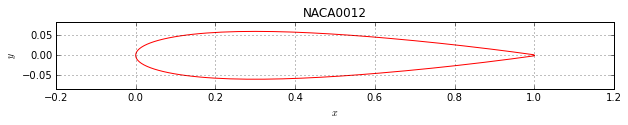

In [95]:
pyplot.figure(figsize=(size, size*(y_up-y_down)/(x_right-x_left)))
pyplot.grid(True)
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$y$')
pyplot.title('NACA0012')
pyplot.xlim(x_left, x_right)
pyplot.ylim(y_down, y_up)
pyplot.plot(x, y, 'r-');

#### Define the panel class

In [96]:
class Panel:
    def __init__(self, xa, ya, xb, yb):
        self.xa, self.ya = xa, ya
        self.xb, self.yb = xb, yb
        self.xc, self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)
        if xb-xa <= 0.:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
        if self.beta <= numpy.pi:
            self.loc = 'extrados'
        else:
            self.loc = 'intrados'
        
        self.sigma = 0.
        self.vt = 0.
        self.cp = 0.

#### Generate panels from airfoil data

In [97]:
def gen_panels(x, y, N=40):
    R = (x.max()-x.min())/2  
    x_center = (x.max()+x.min())/2      
    x_circle = x_center + R*numpy.cos(numpy.linspace(0, 2*numpy.pi, N+1))
    
    x_ends = numpy.copy(x_circle)
    y_ends = numpy.empty_like(x_ends)
    x, y = numpy.append(x, x[0]), numpy.append(y, y[0])
    
    I = 0
    for i in xrange(N):
        while I < len(x)-1:
            if (x[I] <= x_ends[i] <= x[I+1]) or (x[I+1] <= x_ends[i] <= x[I]):
                break
            else:
                I += 1
        a = (y[I+1]-y[I])/(x[I+1]-x[I])
        b = y[I+1] - a*x[I+1]
        y_ends[i] = a*x_ends[i] + b
    y_ends[N] = y_ends[0]
    
    panels = numpy.empty(N, dtype=object)
    for i in xrange(N):
        panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])
    
    return panels

In [98]:
N = 40
panels= gen_panels(x, y, N)

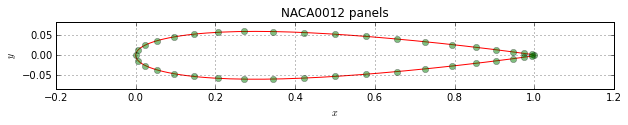

In [99]:
pyplot.figure(figsize=(size, size*(y_up-y_down)/(x_right-x_left)))
pyplot.grid(True)
pyplot.xlabel(r'$x$')
pyplot.ylabel(r'$y$')
pyplot.title('NACA0012 panels')
pyplot.xlim(x_left, x_right)
pyplot.ylim(y_down, y_up)
pyplot.plot(x, y, 'r-')
pyplot.plot([panel.xa for panel in panels], [panel.ya for panel in panels], 'go', alpha=0.5);

#### Generate Freestream Conditions

In [100]:
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = alpha*numpy.pi/180

In [101]:
u_inf = 1.0
alpha = 4.0
freestream = Freestream(u_inf, alpha)

#### Flow tangency boundary condition at each center

$$
\begin{align*}
\phi\left(x_{c_i},y_{c_i}\right) &= V_\infty x_{c_i} \cos \alpha + V_\infty y_{c_i} \sin \alpha \\
&+ \sum_{j=1}^N \frac{\sigma_j}{2\pi} \int_j \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j \\
&- \sum_{j=1}^N \frac{\gamma}{2\pi} \int_j \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

$$0 = \underline{V}\cdot\underline{n}_i = \frac{\partial}{\partial n_i} \left\{ \phi\left(x_{c_i},y_{c_i}\right) \right\}$$

$$\frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) = \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial n_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2}$$

$$\frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right)= \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial n_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial n_i}}{\left(x_{c_i}-x_j\right)^2 + \left(y_{c_i}-y_j\right)^2}$$

where

$$x_j(s_j) = x_{b_j} - s_j \sin \beta_j$$

$$y_j(s_j) = y_{b_j} + s_j \cos \beta_j$$

$$\frac{\partial x_{c_i}}{\partial n_i} = \cos \beta_i  \hspace{10mm} \frac{\partial y_{c_i}}{\partial n_i} = \sin \beta_i$$

If there are $N$ panels, there will be $N+1$ unknowns (source and vortex strength), and there are $N$ equations above. So we still need one more equation. That's Kutta-Condition. 

#### Enforcing Kutta-condition

To enforce the *Kutta-condition*, we state that the pressure coefficient on the fisrt panel must be equal to that on the last panel:

$$C_{p_1} = C_{p_{N}}$$

Using the definition of the pressure coefficient $C_p = 1-\left(\frac{V}{U_\infty}\right)^2$, the Kutta-condition implies that the magnitude of the velocity at the first panel center must equal the magnitude of the last panel center:

$$V_1^2 = V_N^2$$

Since the flow tangency condition requires that $V_{n_1} = V_{n_N} = 0$, we end up with the following *Kutta-condition*:

$$V_{t_1} = - V_{t_N}$$

(the minus sign comes from the reference axis we chose for the normal and tangential vectors).

$$V_{t_i} = \frac{\partial}{\partial t_i} \left(\phi\left(x_{c_i},y_{c_i}\right)\right)$$

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

$$\frac{\partial x_{c_i}}{\partial t_i} = -\sin \beta_i \hspace{10mm} \frac{\partial y_{c_i}}{\partial t_i} = \cos \beta_i$$

In [102]:
def integral(x, y, panel, dxdz, dydz):
    """Return the integral, dz is the direction. x,y are the evaluated point
    """
    def func(s):
        return ( ((x - (panel.xa - numpy.sin(panel.beta)*s))*dxdz 
                  + (y - (panel.ya + numpy.cos(panel.beta)*s))*dydz)
                / ((x - (panel.xa - numpy.sin(panel.beta)*s))**2 
                   + (y - (panel.ya + numpy.cos(panel.beta)*s))**2) )
    return integrate.quad(lambda s:func(s), 0., panel.length)[0]

#### Building the linear system

$$[A][\sigma,\gamma] = [b]$$

In [103]:
def source_matrix(panels):
    A = numpy.empty((panels.size, panels.size), dtype=float)
    numpy.fill_diagonal(A, 0.5)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                A[i,j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.cos(p_i.beta), numpy.sin(p_i.beta))
    
    return A

In [104]:
def vortex_array(panels):
    a = numpy.zeros(panels.size, dtype=float)
    
    for i, p_i in enumerate(panels):
        for j, p_j in enumerate(panels):
            if i != j:
                a[i] -= 0.5/numpy.pi*integral(p_i.xc, p_i.yc, p_j, numpy.sin(p_i.beta), -numpy.cos(p_i.beta))
    return a

$$
\begin{align*}
V_{t_i} &= V_\infty \sin \left(\alpha-\beta_i\right) \\
&+ \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial x_{c_i}}{\partial t_i} + \left(y_{c_i}-y_j\right)\frac{\partial y_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&- \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\left(x_{c_i}-x_j\right)\frac{\partial y_{c_i}}{\partial t_i} - \left(y_{c_i}-y_j\right)\frac{\partial x_{c_i}}{\partial t_i}}{\left(x_{c_i}-x_j\right)^2 + \left(x_{c_i}-x_j\right)^2} {\rm d}s_j \\
&-\frac{\gamma}{2}
\end{align*}
$$

In [105]:
def kutta_array(panels):
    """Builds the Kutta-condition array.
    return a -- 1D array (Nx1, N is the number of panels).
    """
    N = panels.size
    a = numpy.zeros(N+1, dtype=float)
    # contribution from the source sheet of the first panel on the last one
    a[0] = 0.5/numpy.pi*integral(panels[N-1].xc, panels[N-1].yc, panels[0], 
                           -numpy.sin(panels[N-1].beta), +numpy.cos(panels[N-1].beta))
    # contribution from the source sheet of the last panel on the first one
    a[N-1] = 0.5/numpy.pi*integral(panels[0].xc, panels[0].yc, panels[N-1], 
                             -numpy.sin(panels[0].beta), +numpy.cos(panels[0].beta))
    # contribution from the vortex sheet of the first panel on the last one
    a[N] -= 0.5/numpy.pi*integral(panels[-1].xc, panels[-1].yc, panels[0], 
                               +numpy.cos(panels[-1].beta), numpy.sin(panels[-1].beta))
    # contribution from the vortex sheet of the last panel on the first one
    a[N] -= 0.5/numpy.pi*integral(panels[0].xc, panels[0].yc, panels[-1], 
                               +numpy.cos(panels[0].beta), numpy.sin(panels[0].beta))
    # contribution from the vortex sheet of the first panel on itself
    a[N] -= 0.5
    # contribution from the vortex sheet of the last panel on itself
    a[N] -= 0.5
 
    # contribution from the other panels on the first and last ones
    for i, panel in enumerate(panels[1:-1]):
        # contribution from the source sheet
        a[i+1] = 0.5/numpy.pi*(integral(panels[0].xc, panels[0].yc, panel, 
                               -numpy.sin(panels[0].beta), +numpy.cos(panels[0].beta))
                     + integral(panels[N-1].xc, panels[N-1].yc, panel, 
                               -numpy.sin(panels[N-1].beta), +numpy.cos(panels[N-1].beta)) )

        # contribution from the vortex sheet
        a[N] -= 0.5/numpy.pi*(integral(panels[0].xc, panels[0].yc, panel, 
                               +numpy.cos(panels[0].beta), numpy.sin(panels[0].beta))
                             + integral(panels[-1].xc, panels[-1].yc, panel, 
                               +numpy.cos(panels[-1].beta), numpy.sin(panels[-1].beta)) )
        
    return a

In [106]:
def build_matrix(panels):
    N = len(panels)
    A = numpy.empty((N+1, N+1), dtype=float)
    
    AS = source_matrix(panels)
    av = vortex_array(panels)
    ak = kutta_array(panels)
    
    A[0:N,0:N], A[0:N,N], A[N,:] = AS[:,:], av[:], ak[:]
    
    return A

In [107]:
def build_rhs(panels, freestream):
    N = len(panels)
    b = numpy.empty(N+1,dtype=float)
    
    for i, panel in enumerate(panels):
        b[i] = - freestream.u_inf * numpy.cos(freestream.alpha - panel.beta)
    b[N] = -freestream.u_inf*( numpy.sin(freestream.alpha-panels[0].beta)
                              +numpy.sin(freestream.alpha-panels[N-1].beta) )
    
    return b

In [108]:
A = build_matrix(panels)
b = build_rhs(panels, freestream)

In [109]:
# solves the linear system
solution = numpy.linalg.solve(A, b)

for i, panel in enumerate(panels):
    panel.sigma = solution[i]
gamma = solution[-1]

#### Check the accurary

In [110]:
# calculates the accuracy
accuracy = sum([panel.sigma*panel.length for panel in panels])
print '--> sum of source/sink strengths:', accuracy

--> sum of source/sink strengths: 0.00460578431939


#### Calculate Surface tangential velocity

In [111]:
def get_tangential_velocity(panels, freestream, gamma):
    N = len(panels)
    A = numpy.empty((N, N+1), dtype=float)
    numpy.fill_diagonal(A, 0.0)
    
    for i, p_i in enumerate(panels):
        # contribution from vortex on itself
        A[i, N] = -0.5
        for j, p_j in enumerate(panels):
            if i != j:
                # contribution from the sources
                A[i,j] = 0.5/numpy.pi*integral(p_i.xc, p_i.yc, 
                                              p_j, 
                                              -numpy.sin(p_i.beta), numpy.cos(p_i.beta))
                # contribution the vortices
                A[i,N] -= 0.5/numpy.pi*integral(p_i.xc, p_i.yc, 
                                               p_j, 
                                               numpy.cos(p_i.beta), numpy.sin(p_i.beta))

    b = freestream.u_inf * numpy.sin([freestream.alpha - panel.beta for panel in panels])
    
    var = numpy.append([panel.sigma for panel in panels], gamma)
    
    vt = numpy.dot(A, var) + b
    for i, panel in enumerate(panels):
        panel.vt = vt[i]

In [112]:
get_tangential_velocity(panels, freestream, gamma)

#### Calculate Pressure Coefficient 

In [113]:
def get_pressure_coefficient(panels, freestream):
    for panel in panels:
        panel.cp = 1.0 - (panel.vt/freestream.u_inf)**2

In [114]:
get_pressure_coefficient(panels, freestream)

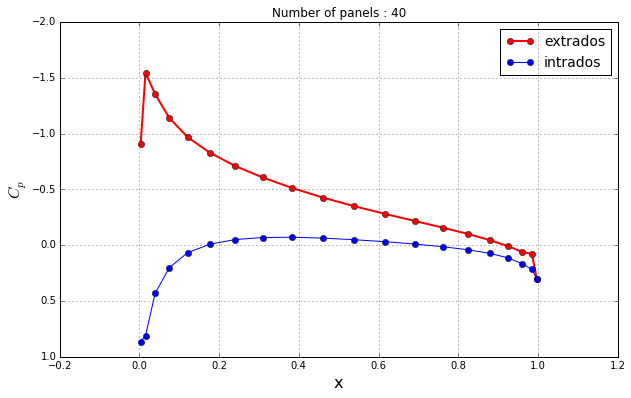

In [115]:
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'extrados'], 
         [panel.cp for panel in panels if panel.loc == 'extrados'], 
         color='r', linestyle='-', linewidth=2, marker='o', markersize=6)
pyplot.plot([panel.xc for panel in panels if panel.loc == 'intrados'], 
         [panel.cp for panel in panels if panel.loc == 'intrados'], 
         color='b', linestyle='-', linewidth=1, marker='o', markersize=6)
pyplot.legend(['extrados', 'intrados'], loc='best', prop={'size':14})
pyplot.xlim(x_left, x_right)
pyplot.gca().invert_yaxis()
pyplot.title('Number of panels : %d' % N);

#### Calculate the Streamline on a cartesian grid

In [128]:
scale = 2.0
x_left, x_right = x_air_min-scale*(x_air_max-x_air_min), x_air_max+scale*(x_air_max-x_air_min)
y_down, y_up = y_air_min-scale*(y_air_max-y_air_min), y_air_max+scale*(y_air_max-y_air_min)

In [129]:
Nx, Ny = 40, 40
X, Y = numpy.meshgrid(numpy.linspace(x_left, x_right, Nx), numpy.linspace(y_down, y_up, Ny))

In [130]:
def get_velocity_field(panels, freestream, gamma, X,Y):
    Nx, Ny = X.shape
    u, v = numpy.empty((Nx, Ny), dtype=float), numpy.empty((Nx, Ny), dtype=float)
    
    for i in xrange(Nx):
        for j in xrange(Ny):
            u[i,j] = freestream.u_inf*numpy.cos(freestream.alpha)\
                     + 0.5/numpy.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])\
                     - 0.5/numpy.pi*sum([gamma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])
            v[i,j] = freestream.u_inf*numpy.sin(freestream.alpha)\
                     + 0.5/numpy.pi*sum([p.sigma*integral(X[i,j], Y[i,j], p, 0, 1) for p in panels])\
                     - 0.5/numpy.pi*sum([gamma*integral(X[i,j], Y[i,j], p, 1, 0) for p in panels])
    return u, v

In [131]:
u, v = get_velocity_field(panels, freestream, gamma, X, Y)

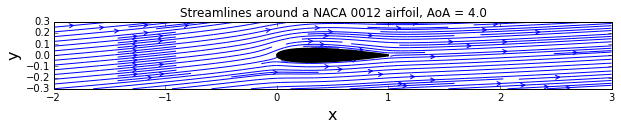

In [132]:
# plots the velocity field
size=10
pyplot.figure(figsize=(size, size*(y_up-y_down)/(x_right-x_left)))
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.streamplot(X, Y, u, v, density=1, linewidth=1, arrowsize=1, arrowstyle='->')
pyplot.fill([panel.xc for panel in panels], 
         [panel.yc for panel in panels], 
         color='k', linestyle='solid', linewidth=2, zorder=2)
pyplot.xlim(x_left, x_right)
pyplot.ylim(y_down, y_up)
pyplot.title('Streamlines around a NACA 0012 airfoil, AoA = %.1f' % alpha);